In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/clean.csv")
data = data[['price', 'zip_code', 'living_space', 'rooms', 'type']]
plz  = pd.read_csv("https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/plz_data.csv") 

In [3]:
data["type"].unique()

array(['penthouse', 'terrace-house', 'detached-house', 'flat',
       'stepped-house', 'farmhouse', 'semi-detached-house',
       'stepped-apartment', 'duplex-maisonette', 'attic-flat', 'loft',
       'chalet', 'villa', 'attic-room', 'secondary-suite', 'castle',
       'detached-secondary-suite', 'studio',
       'furnished-residential-property', 'rustico', 'single-room'],
      dtype=object)

In [4]:
data = pd.get_dummies(data, columns=["type"])
data = data.merge(plz, how = 'inner', left_on = "zip_code", right_on = "PLZ")
data = data.drop(columns = ["PLZ", "zip_code"])

print(len(data))
data

13069


,price,living_space,rooms,type_attic-flat,type_attic-room,type_castle,type_chalet,type_detached-house,type_detached-secondary-suite,type_duplex-maisonette,...,PLZ_Group_9000,PLZ_Group_9100,PLZ_Group_9200,PLZ_Group_9300,PLZ_Group_9400,PLZ_Group_9500,PLZ_Group_9600,PLZ_Group_9700,PLZ_Group_9800,PLZ_Group_9900
0,1150000.0,100.0,3.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1420000.0,156.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1430000.0,154.0,4.5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,550000.0,124.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,720000.0,93.0,2.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13064,895000.0,130.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13065,1090000.0,147.0,5.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13066,2750000.0,385.0,7.5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
13067,1415000.0,150.0,6.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data.isna().sum().sort_values(ascending = False)

living_space                         1069
price                                1025
rooms                                 582
PLZ_Group_9800                          0
PLZ_Group_4100                          0
                                     ... 
NoisePollutionRailwayL                  0
gde_politics_fdp                        0
gde_social_help_quota                   0
gde_area_nonproductive_percentage       0
PLZ_Group_9900                          0
Length: 162, dtype: int64

In [6]:
data = data.dropna()
len(data)

10923

In [7]:
y_cols = data.columns[data.columns.str.startswith("type_")]
X_cols = list(set(data._get_numeric_data().columns) - set(y_cols))

X = data[X_cols].values
y = data[y_cols].values

In [8]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420)

In [9]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test  = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test  = torch.from_numpy(y_test.astype(np.float32))

In [10]:
class Gabonisator(torch.nn.Module):
    # run super and define layers
    def __init__(self, n_features, n_outputs):
        super(Gabonisator, self).__init__()
        self.hidden1 = torch.nn.Linear(n_features, 64)
        self.hidden2 = torch.nn.Linear(64, 64)
        self.output = torch.nn.Linear(64, n_outputs)

    # define forward prop
    def forward(self, X):
        y_pred = self.hidden1(X)
        y_pred = torch.relu(y_pred)
        y_pred = self.hidden2(y_pred)
        y_pred = torch.relu(y_pred)
        y_pred = self.output(y_pred)
        y_pred = torch.softmax(y_pred, dim = 1)
        return y_pred

In [11]:
# create model
model = Gabonisator(X.shape[1], y.shape[1])

# define learning rate, loss function and optimizer
learning_rate = 0.0003
lossf = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

# loss tracker
score_tracker = []

# define iterations and iterate (training)
n_epochs = 3000
for epoch in tqdm(range(n_epochs)):
    # forward prop
    y_pred = model(X_train)
    # loss function
    loss = lossf(y_pred, y_train)
    # back prop
    loss.backward()
    # update params with optimizer
    optim.step()
    # empty gradients
    optim.zero_grad()
    # save score <- this step is very slow, for bigger models do this every n epochs
    score = ((model(X_test).argmax(axis = 1) == y_test.argmax(axis = 1)).sum() / y_test.shape[0]).item()
    score_tracker.append(score)
    # print info 
    #if (epoch + 1) % 200 == 0: <- not printing because of tqdm progress bar
    #    print(f'Epoch: {epoch + 1}')
    #    print(f'Loss:  {loss.item()}')
    #    print(f'Score: {score:.4f}')
    #    print()
        
with torch.no_grad():
    print(f'Final Run')
    print(f'Loss:  {loss.item():.4f}')
    score = ((model(X_test).argmax(axis = 1) == y_test.argmax(axis = 1)).sum() / y_test.shape[0]).item()
    print(f'Score: {score:.4f}')
    print(f'   Best Score: {np.max(score_tracker):.4f} at Epoch {np.argmax(score_tracker) + 1}')
    

100%|██████████| 3000/3000 [00:16<00:00, 184.26it/s]

Final Run
Loss:  0.0396
Score: 0.5816
   Best Score: 0.6396 at Epoch 632


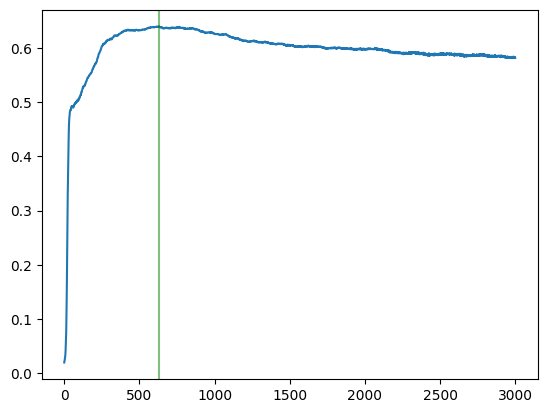

In [12]:
plt.plot(score_tracker)
plt.axvline(np.argmax(score_tracker), color = 'green', alpha = 0.5)
plt.show()

TODO: Logik für frühzeitiges Abbrechen implementieren um Overfitting zu verhindern.

Die Architektur unseres neuronalen Netzes sieht so aus:

<svg xmlns="http://www.w3.org/2000/svg" style="cursor: move; background: white;" width="380" height="185"><g transform="translate(-743.5554710569938,-326.8616196843533)scale(1.1)"><polygon class="poly" id="fc_0" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="718.5,344.6489719263484 728.5,344.6489719263484 828.2020561473032,444.3510280736516 818.2020561473032,444.3510280736516"></polygon><polygon class="poly" id="fc_1" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="830.2020561473032,371.87258300203047 840.2020561473032,371.87258300203047 885.4568901432423,417.1274169979695 875.4568901432423,417.1274169979695"></polygon><polygon class="poly" id="fc_2" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="887.4568901432422,371.87258300203047 897.4568901432422,371.87258300203047 942.7117241391812,417.1274169979695 932.7117241391812,417.1274169979695"></polygon><polygon class="poly" id="fc_3" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="944.7117241391812,387.07537879754125 954.7117241391812,387.07537879754125 969.5609665440987,401.92462120245875 959.5609665440987,401.92462120245875"></polygon><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="818.2020561473032" y2="444.3510280736516"></line><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="718.5" y2="344.6489719263484"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="828.2020561473032" y1="444.3510280736516" x2="875.4568901432422" y2="417.1274169979695"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="728.5" y1="344.6489719263484" x2="830.2020561473032" y2="371.87258300203047"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="885.4568901432422" y1="417.1274169979695" x2="932.7117241391812" y2="417.1274169979695"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="840.2020561473032" y1="371.87258300203047" x2="887.4568901432422" y2="371.87258300203047"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="942.7117241391812" y1="417.1274169979695" x2="959.5609665440987" y2="401.92462120245875"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="897.4568901432422" y1="371.87258300203047" x2="944.7117241391812" y2="387.07537879754125"></line><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="718.5" y="329.6489719263484">1x141</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="830.2020561473032" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="887.4568901432422" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="944.7117241391812" y="372.07537879754125">1x21</text></g></svg>